# Import librarys and Data

In [36]:
#import important liberies Important!! usse  python 3.11 or below
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [37]:
import numpy as np
import pandas as pd
from typing import Tuple

# Configuration for normal (fault-free) operation
PROCESS_CONFIG: dict[str, dict[str, object]] = {
    'welding_temp':        {'mean': 350, 'std': 10, 'dist': 'normal'},
    'clamp_pressure':      {'mean': 5.0, 'std': 0.5, 'dist': 'normal'},
    'robot_torque':        {'mean': 120, 'std': 15, 'dist': 'normal'},
    'paint_viscosity':     {'mean': 0.85, 'std': 0.1, 'dist': 'lognormal'},
    'conveyor_speed':      {'mean': 1.5, 'std': 0.2, 'dist': 'normal'},
    'ambient_temp':        {'mean': 25, 'std': 2, 'dist': 'normal'},
    'humidity':            {'dist': 'uniform', 'low': 30, 'high': 60},
    'sensor_drift':        {'dist': 'exponential', 'scale': 0.1},
    'cycle_time':          {'dist': 'chi2', 'df': 4},
    'quality_score':       {'dist': 'beta', 'a': 2, 'b': 5},
    'robot_current':       {'formula': 'robot_torque * 0.08 + noise(0.5)'},
    'weld_time':           {'formula': '350 / welding_temp + noise(0.01)'},
    'spray_pressure':      {'formula': 'np.sin(paint_viscosity * 3) * 5 + 10 + noise(0.5)'},
    'dynamic_A':           {'mean': 50, 'std': 5, 'dist': 'normal'},
    'dynamic_B':           {'mean': 100, 'std': 10, 'dist': 'normal'},
    'formula_X':           {'formula': 'np.log1p(cycle_time) * 3 + noise(0.2)'},
    'formula_Y':           {'formula': 'np.sqrt(ambient_temp) * 2 + noise(0.2)'},
}

# Fault injection configuration (multi-variable, type-controlled)
FAULT_CONFIG: dict[int, list[dict[str, object]]] = {
    1: [  # One fault only
        {'var': 'welding_temp', 'type': 'trend', 'slope': 0.2},
        {'var': 'dynamic_A', 'type': 'trend', 'slope': 0.3},
        {'var': 'formula_Y', 'type': 'trend', 'slope': -0.2},
        
    ],
    2: [  # 2 faults
        {'var': 'clamp_pressure', 'type': 'drift', 'end': 3},
        {'var': 'cycle_time', 'type': 'spike', 'prob': 0.3, 'scale': 3}
    ],
    3: [  # 3 faults
        {'var': 'robot_torque', 'type': 'shift', 'value': 20},
        {'var': 'weld_time', 'type': 'flat', 'start': 100, 'length': 50},
        {'var': 'robot_current', 'type': 'cos'}
    ],
    4: [  # 4 faults
        {'var': 'paint_viscosity', 'type': 'drop', 'magnitude': -0.4, 'at': 100},
        {'var': 'conveyor_speed', 'type': 'invert'},
        {'var': 'robot_current', 'type': 'noise', 'scale': 4},
        {'var': 'welding_temp', 'type': 'trend', 'slope': 0.1}
    ],
    5: [  # 5 faults
        {'var': 'ambient_temp', 'type': 'sin', 'amp': 2},
        {'var': 'humidity', 'type': 'trend', 'slope': -0.1},
        {'var': 'sensor_drift', 'type': 'drift', 'end': 0.4},
        {'var': 'paint_viscosity', 'type': 'shift', 'value': 0.3},
        {'var': 'cycle_time', 'type': 'spike', 'prob': 0.4, 'scale': 2}
    ],
    6: [  # 6 faults
        {'type': 'correlated_shift', 'vars': ['robot_torque', 'robot_current'], 'value': 10},
        {'var': 'robot_torque', 'type': 'trend', 'slope': 0.3},
        {'var': 'weld_time', 'type': 'flat', 'start': 50, 'length': 60},
        {'var': 'conveyor_speed', 'type': 'drift', 'end': 0.2},
        {'var': 'ambient_temp', 'type': 'shift', 'value': 5},
        {'var': 'clamp_pressure', 'type': 'noise', 'scale': 1}
    ],
    7: [{'var': 'quality_score', 'type': 'cos'},
        {'var': 'welding_temp', 'type': 'trend', 'slope': -0.1}],
    8: [{'var': 'cycle_time', 'type': 'invert'},
        {'var': 'sensor_drift', 'type': 'drift', 'end': -0.5},
        {'var': 'robot_torque', 'type': 'spike', 'prob': 0.3, 'scale': 15}],
    9: [{'var': 'paint_viscosity', 'type': 'shift', 'value': 0.5},
        {'var': 'robot_current', 'type': 'trend', 'slope': 0.1},
        {'var': 'welding_temp', 'type': 'drift', 'end': 10},
        {'var': 'ambient_temp', 'type': 'flat', 'start': 70, 'length': 30}],
    10: [{'type': 'correlated_shift', 'vars': ['robot_torque', 'weld_time'], 'value': 12}],
    11: [{'var': 'sensor_drift', 'type': 'trend', 'slope': 0.2},
         {'var': 'cycle_time', 'type': 'spike', 'prob': 0.5, 'scale': 5}],
    12: [{'var': 'ambient_temp', 'type': 'sin', 'amp': 5},
         {'var': 'clamp_pressure', 'type': 'drop', 'magnitude': -.5, 'at': 0}],
    13: [{'var': 'humidity', 'type': 'drift', 'end': 8},
         {'var': 'quality_score', 'type': 'trend', 'slope': -0.2},
         {'var': 'robot_current', 'type': 'noise', 'scale': 2}],
    14: [{'var': 'robot_torque', 'type': 'shift', 'value': 25},
         {'var': 'welding_temp', 'type': 'trend', 'slope': 0.1},
         {'var': 'robot_current', 'type': 'stuck'}],
    15: [{'var': 'cycle_time', 'type': 'invert'},
         {'var': 'humidity', 'type': 'flat', 'start': 90, 'length': 50},
         {'var': 'spray_pressure', 'type': 'noise', 'scale': 3}],
    16: [{'type': 'correlated_shift', 'vars': ['ambient_temp', 'humidity'], 'value': 5}],
    17: [{'var': 'robot_current', 'type': 'drift', 'end': -2},
         {'var': 'robot_torque', 'type': 'trend', 'slope': -0.2},
         {'var': 'clamp_pressure', 'type': 'shift', 'value': 1}],
    18: [{'var': 'conveyor_speed', 'type': 'drop', 'magnitude': -0.1, 'at': 0}],
    19: [{'var': 'quality_score', 'type': 'cos'},
         {'var': 'robot_torque', 'type': 'shift', 'value': -10}],
    20: [{'type': 'correlated_shift', 'vars': ['welding_temp', 'spray_pressure'], 'value': 8},
         {'var': 'paint_viscosity', 'type': 'sin', 'amp': 4},
         {'var': 'robot_current', 'type': 'noise', 'scale': 2}],
}

def noise(std: float, size: int) -> np.ndarray:
    return np.random.normal(0, std, size=size)

def add_random_dynamic_and_noise(df: pd.DataFrame, n_samples: int, seed:int) -> pd.DataFrame:
    rng = np.random.default_rng(seed) 

    # Dynamic drift random length and start
    min_dyn_len = n_samples // 10
    max_dyn_len = n_samples // 2
    dynamic_length = rng.integers(min_dyn_len, max_dyn_len + 1)
    dynamic_start = rng.integers(0, n_samples - dynamic_length + 1)

    drift_A = np.linspace(0, 10, dynamic_length)
    drift_B = np.linspace(0, 20, dynamic_length)

    df.loc[dynamic_start:dynamic_start + dynamic_length - 1, 'dynamic_A'] += drift_A
    df.loc[dynamic_start:dynamic_start + dynamic_length - 1, 'dynamic_B'] += drift_B

    # Random noise region random start and length
    min_rand_len = n_samples // 20
    max_rand_len = n_samples // 3
    random_length = rng.integers(min_rand_len, max_rand_len + 1)
    random_start = rng.integers(0, n_samples - random_length + 1)

    mask = np.zeros(n_samples, dtype=bool)
    mask[random_start:random_start + random_length] = True
    rng.shuffle(mask)

    df.loc[mask, 'formula_X'] += rng.normal(3, 1, size=mask.sum())
    df.loc[mask, 'formula_Y'] += rng.normal(-2, 1, size=mask.sum())

    return df

def simulate_normal_data(n_samples: int, seed: int = 42) -> pd.DataFrame:
    np.random.seed(seed)
    df = pd.DataFrame(index=range(n_samples))

    for var, cfg in PROCESS_CONFIG.items():
        if 'formula' in cfg:
            continue
        dist = cfg['dist']
        if dist == 'normal':
            df[var] = np.random.normal(cfg['mean'], cfg['std'], n_samples)
        elif dist == 'lognormal':
            mu = np.log(cfg['mean']**2 / np.sqrt(cfg['std']**2 + cfg['mean']**2))
            sigma = np.sqrt(np.log(1 + (cfg['std']**2 / cfg['mean']**2)))
            df[var] = np.random.lognormal(mu, sigma, n_samples)
        elif dist == 'uniform':
            df[var] = np.random.uniform(cfg['low'], cfg['high'], n_samples)
        elif dist == 'exponential':
            df[var] = np.random.exponential(cfg['scale'], n_samples)
        elif dist == 'chi2':
            df[var] = np.random.chisquare(cfg['df'], n_samples)
        elif dist == 'beta':
            df[var] = np.random.beta(cfg['a'], cfg['b'], n_samples)


    for var, cfg in PROCESS_CONFIG.items():
        if 'formula' not in cfg:
            continue
        context = df.to_dict(orient='series')
        df[var] = eval(cfg['formula'], {'np': np, 'noise': lambda std: noise(std, n_samples)}, context)

    df = add_random_dynamic_and_noise(df, n_samples, seed)

    df['faultNumber'] = 0.0
    return df

def inject_fault(df: pd.DataFrame, fault_number: int) -> pd.DataFrame:
    df_fault = df.copy()
    np.random.seed(fault_number + 100)
    fault_ops = FAULT_CONFIG.get(fault_number, [])

    for op in fault_ops:
        fault_type = op['type']

        # Handle correlated shift separately
        if fault_type == 'correlated_shift':
            targets: list[str] = op['vars']
            shift: float = op['value']
            for v in targets:
                if v in df_fault.columns:
                    df_fault[v] += shift
            continue

        # Otherwise, expect a single target variable
        var = op.get('var')
        if var not in df_fault.columns:
            continue

        if fault_type == 'shift':
            df_fault[var] += op['value']
        elif fault_type == 'drift':
            df_fault[var] += np.linspace(0, op['end'], len(df_fault))
        elif fault_type == 'noise':
            df_fault[var] += np.random.normal(0, op['scale'], size=len(df_fault))
        elif fault_type == 'stuck':
            df_fault[var] = df_fault[var].iloc[0]
        elif fault_type == 'invert':
            df_fault[var] = df_fault[var].max() - df_fault[var]
        elif fault_type == 'sin':
            df_fault[var] += op.get('amp', 1) * np.sin(np.linspace(0, 10 * np.pi, len(df_fault)))
        elif fault_type == 'cos':
            df_fault[var] += 0.5 * np.cos(df_fault['humidity'] / 10)
        elif fault_type == 'trend':
            slope = op.get('slope', 0.1)
            df_fault[var] += slope * np.arange(len(df_fault))
        elif fault_type == 'drop':
            idx = op.get('at', len(df_fault) // 2)
            magnitude = op.get('magnitude', -5)
            df_fault.loc[idx:, var] += magnitude
        elif fault_type == 'spike':
            prob = op.get('prob', 0.01)
            scale = op.get('scale', 20)
            spikes = np.random.choice([0, 1], size=len(df_fault), p=[1 - prob, prob])
            df_fault[var] += spikes * np.random.normal(scale, scale / 2, size=len(df_fault))
        elif fault_type == 'flat':
            start = op.get('start', 50)
            length = op.get('length', 30)
            df_fault.iloc[start:start + length, df_fault.columns.get_loc(var)] = df_fault[var].iloc[start]

    df_fault['faultNumber'] = fault_number
    return df_fault


def reorder_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns.tolist()
    for c in ['faultNumber', 'simulationRun', 'sample']:
        if c in cols:
            cols.remove(c)
    new_order = ['faultNumber', 'simulationRun', 'sample'] + cols
    return df[new_order]

def generate_dataset(
    n_normal_simulations: int = 20,
    n_faulty_simulations_per_fault: int = 20,
    n_samples_per_simulation: int = 200
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    normal_runs = []
    faulty_runs = []

    shared_seeds = list(range(1, max(n_normal_simulations, n_faulty_simulations_per_fault) + 1))

    for run_id, seed in enumerate(shared_seeds[:n_normal_simulations], start=1):
        df = simulate_normal_data(n_samples_per_simulation, seed=seed)
        df['simulationRun'] = run_id
        df['sample'] = np.arange(1, n_samples_per_simulation + 1)
        df = reorder_columns(df)
        normal_runs.append(df)

    for fault_id in range(1, 21):
        for sim_index, seed in enumerate(shared_seeds[:n_faulty_simulations_per_fault], start=1):
            df = simulate_normal_data(n_samples_per_simulation, seed=seed)
            df = inject_fault(df, fault_number=fault_id)
            df['simulationRun'] = sim_index
            df['sample'] = np.arange(1, n_samples_per_simulation + 1)
            df = reorder_columns(df)
            faulty_runs.append(df)

    df_ff_training = pd.concat(normal_runs, ignore_index=True)
    df_f_training = pd.concat(faulty_runs, ignore_index=True)
    return df_ff_training, df_f_training


In [38]:
df_ff_training, df_f_training = generate_dataset()
df_ff_test, df_f_test = generate_dataset()

In [39]:
faultNumber=2.0
simulationRun = 1
df_selected_f_data = df_f_training[(df_f_training['faultNumber'] == faultNumber) & (df_f_training['simulationRun'] == simulationRun)]
df_selected_f_data.head()  # Display the first few rows of the selected fault data

faultNumber  simulationRun  sample  welding_temp  clamp_pressure  \
4000            2              1       1    366.243454        4.799561   
4001            2              1       2    343.882436        5.427078   
4002            2              1       3    344.718282        4.748998   
4003            2              1       4    339.270314        6.022665   
4004            2              1       5    358.654076        4.394326   

      robot_torque  paint_viscosity  conveyor_speed  ambient_temp   humidity  \
4000    100.401989         0.744391        1.662869     24.693528  59.696504   
4001    121.145707         0.894636        1.656094     20.134983  35.322886   
4002    125.508477         0.755017        1.207189     26.015969  54.643402   
4003    138.493488         0.794422        1.469102     24.351935  36.929657   
4004    113.657146         0.711250        1.481514     21.977847  31.739274   

      sensor_drift  cycle_time  quality_score  dynamic_A   dynamic_B  \
4000      0.160774    7.338356       0.217906  52.794664  102.496710   
4001      0.069795    3.867285       0.523805  49.771500   93.368442   
4002      0.008685   11.023051       0.358397  50.445588  111.139527   
4003      0.150051    3.563484       0.304553  50.526787   91.221485   
4004      0.076282    2.680922       0.148604  49.335171  105.625418   

      robot_current  weld_time  spray_pressure  formula_X  formula_Y  
4000       8.547536   0.964946       13.614927   6.394668   9.969751  
4001       9.517688   1.004238       12.651078   4.711208   8.654476  
4002      10.581421   1.026073       13.864310   7.090200  10.121407  
4003      11.579872   1.043942       13.015537   1.947749   9.729547  
4004       9.317370   0.973115       14.201618   3.588143   9.694276

# Custom functions

In [40]:
# Compare fault vs normal time series for selected features.
# This help to caputre the differences between faulty and normal segments of the time series data and determine the start of the fault injection.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_fault_vs_normal_segment(
    df_fault: pd.DataFrame,
    df_normal: pd.DataFrame,
    features: list[str],
    point_start: int,
    point_end: int,
    fault_number: int,
    fault_injection_index: int = 160
) -> None:
    """
    Compare fault vs normal time series for selected features.

    Parameters:
    - df_fault: DataFrame with faults (should include faultNumber column).
    - df_normal: Normal (non-faulty) baseline DataFrame.
    - features: List of feature names to compare.
    - point_start: Start index of window.
    - point_end: End index of window (exclusive).
    - fault_number: Fault number to extract from df_fault.
    """
    df_fault = df_fault[df_fault['faultNumber'] == fault_number].reset_index(drop=True)
    df_fault_window = df_fault.iloc[point_start:point_end]
    df_normal_window = df_normal.iloc[point_start:point_end]

    x_range = np.arange(point_start, point_end)
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(30, 3 * n_features), sharex=True)

    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        ax = axes[i]

        y_fault = df_fault_window[feature].values
        y_normal = df_normal_window[feature].values
        
        ax.plot(x_range, y_fault, label=f'Fault {fault_number}', color='red')
        ax.plot(x_range, y_normal, label='Normal', color='black')

        # Median lines
        ax.axhline(np.median(y_normal), color='black', linestyle='--', label='Normal Median')
        ax.axhline(np.median(y_fault), color='red', linestyle='--', label='Fault Median')
        ax.axvline(fault_injection_index, color='green', linestyle='--', linewidth=2, label='Fault Injected')
        # Mark every 5th index
        for x in x_range:
            if x % 5 == 0:
                ax.axvline(x, color='gray', linestyle=':', linewidth=0.5)
                ax.text(
                    x,
                    ax.get_ylim()[1],
                    f"{x}",
                    color='gray',
                    fontsize=8,
                    ha='center',
                    va='bottom',
                    rotation=90,
                    backgroundcolor='white'
                )
        ax.set_ylabel(feature)
        ax.grid(True)
        if i == 0:
            ax.legend(loc='best')
    # Place suptitle before tight_layout to ensure it appears above the plots
    #plt.suptitle(f"Comparison of Fault {fault_number} vs Normal", fontsize=14)
    plt.xlabel("Time Index")
    
    plt.tight_layout()
    plt.show()
    

# # usage example

# simulationRun = 8.0
# df_fault = df_f_training[(df_f_training['simulationRun'] == simulationRun)].reset_index(drop=True)
# df_normal = df_ff_training[(df_ff_training['simulationRun'] == simulationRun)].reset_index(drop=True)


# plot_fault_vs_normal_segment(
#     df_fault=df_fault ,
#     df_normal=df_normal,
#     features=df_f_training.columns[3:],
#     point_start=0,
#     point_end=500,
#     fault_number=4,
#     fault_injection_index=25
# )


In [41]:
# Determine the fault insection data point

# This function will plot the feature time series before and after fault injection
# It will also mark the fault injection point and show median values before and after the injection.
# It is useful for visualizing how features change around the time a fault is injected.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_fault_injection_segment(
    df: pd.DataFrame,
    fault_injection_index: int,
    features: list[str],
    fault_number: int,
    point_start: int = 0,
    point_end: int = 500
) -> None:
    """
    Plot feature time series before and after fault injection.

    Parameters:
    - df: DataFrame containing time series (1 simulation run).
    - fault_injection_index: Time step where fault is injected.
    - features: List of feature names to plot.
    - window: Number of time steps before and after injection to show.
    """
    # Filter only the rows with the selected fault number
    df: pd.DataFrame = df[df['faultNumber'] == fault_number].reset_index(drop=True)

    x_range: np.ndarray = np.arange(point_start, point_end)

    df_window: pd.DataFrame = df.iloc[point_start:point_end]

    n_features: int = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(30, 3* n_features), sharex=True)

    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        ax = axes[i]
        y = df_window[feature].values
        ax.plot(x_range, y, label=feature, color='black')
        
        # Mark every 5th time index
        for x in x_range:
            if x % 5 == 0:
                ax.axvline(x, color='gray', linestyle=':', linewidth=0.5)
                ax.text(
                    x,
                    ax.get_ylim()[1],
                    f"{x}",
                    color='gray',
                    fontsize=8,
                    ha='center',
                    va='bottom',
                    rotation=90,
                    backgroundcolor='white'
                )


        # Vertical fault injection marker
        ax.axvline(fault_injection_index, color='red', linestyle='--', linewidth=2, label='Fault Injected')
        

        
        # Text showing the time index
        ax.text(
            fault_injection_index,
            ax.get_ylim()[1],
            f"t={fault_injection_index}",
            color='red',
            fontsize=10,
            ha='center',
            va='bottom',
            rotation=0,
            backgroundcolor='white'
        )

        # Median before/after
        before = df.loc[point_start:fault_injection_index - 1, feature]
        after = df.loc[fault_injection_index:point_end - 1, feature]
        before_med = np.median(before)
        after_med = np.median(after)

        ax.axhline(before_med, color='blue', linestyle=':', label='Median Before')
        ax.axhline(after_med, color='green', linestyle=':', label='Median After')

        ax.set_ylabel(feature)
        ax.grid(True)

        if i == 0:
            ax.legend(loc='best')

    plt.xlabel("Time Index")
    plt.suptitle("Feature Response Around Fault Injection", fontsize=14)
    plt.tight_layout()
    plt.show()

# # Usage example
# df_fault = df_f_training[(df_f_training['simulationRun'] == 2.0)].reset_index(drop=True)

# print(len(df_fault))

# plot_fault_injection_segment(
#     df=df_fault,
#     fault_injection_index=160,
#     #features=['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6'],
#     features=df_fault.columns[3:9],
#     fault_number=1,
#     point_start=1,
#     point_end=500
# )

# Prepare data

In [42]:
# Fault Injection Point and Skipped Faults

target_variable_column_name = 'faultNumber'
columns_to_remove = ['simulationRun', 'sample']
skiped_faults= []

df_f_train_skipped_faults = df_f_training[~df_f_training[target_variable_column_name].isin(skiped_faults)].reset_index(drop=True)
df_f_test_skipped_faults = df_f_test[~df_f_test[target_variable_column_name].isin(skiped_faults)].reset_index(drop=True)

df_training_concated = pd.concat([df_ff_training, df_f_train_skipped_faults])
df_test_concated = pd.concat([df_ff_test,df_f_test_skipped_faults])

In [43]:
# Reduce Training and test data for simplicity during development and testing
fault_injection_point = 0

# Reduce the *train* data to simulation runs between 1 and 10, and samples greater than fault_injection_point = 20
reduced_data_train =df_training_concated[(df_training_concated['simulationRun'] <11 ) & (df_training_concated['sample'] > fault_injection_point)]

# Reduce the *test* data to simulation runs between 1 and 3, and samples greater than 20
reduced_data_test = df_test_concated[(df_test_concated['simulationRun'] > 8 ) & (df_test_concated['sample'] > fault_injection_point)]

print(f"Reduced train data shape: {reduced_data_train.shape}")
print(f"Reduced test data shape: {reduced_data_test.shape}")

Reduced train data shape: (42000, 20)
Reduced test data shape: (50400, 20)


In [44]:
# Prepare data

prepared_data_train = reduced_data_train.drop(columns=columns_to_remove, axis=1)
prepared_data_test = reduced_data_test.drop(columns=columns_to_remove, axis=1)

# Standardize the data: It centers the data around 0 and scales it based on standard deviation.
sc = StandardScaler()
sc.fit(prepared_data_train.drop(columns=[target_variable_column_name], axis=1))

# Set the features and target variable for training
x_train = sc.transform(prepared_data_train.drop(columns=[target_variable_column_name], axis=1))
Y = reduced_data_train[target_variable_column_name]

# Encode the target variable: -LabelEncoder() Takes a list/array of categorical labels (e.g., ['shift', 'trend', 'none']), -Assigns a unique integer to each category (e.g., ['none' → 0, 'shift' → 1, 'trend' → 2]), -Returns a NumPy array of integers corresponding to the original labels
le = LabelEncoder()
y_labeled_train = le.fit_transform(Y)

# Set the features and target variable for testing
x_test = sc.transform(prepared_data_test.drop(columns=[target_variable_column_name], axis=1))
Y_test = reduced_data_test[target_variable_column_name]

# Encode the target variable for testing
y_labeled_test = le.fit_transform(Y_test)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
print(f"Encoder categories: {encoder}")
Y_reshabed = reduced_data_train[target_variable_column_name].to_numpy().reshape(-1, 1)
y_one_hot_vector_enc_train = encoder.fit_transform(Y_reshabed)
Y_test_reshabed = reduced_data_test[target_variable_column_name].to_numpy().reshape(-1, 1)
y_one_hot_vector_enc_test = encoder.transform(Y_test_reshabed)


Encoder categories: OneHotEncoder(sparse_output=False)


In [45]:
import sklearn
print(sklearn.__version__)

1.6.1


In [46]:
# Standardize the data for fault training data or EDA
sc = StandardScaler()
sc.fit(df_f_training.drop(columns=[target_variable_column_name], axis=1))
x_f_train = sc.transform(df_f_training.drop(columns=[target_variable_column_name], axis=1))
y_f_labeled_train = df_f_training[target_variable_column_name].to_numpy()
le = LabelEncoder()
y_f_labeled_train = le.fit_transform(y_f_labeled_train)

sc = StandardScaler()
sc.fit(df_ff_training.drop(columns=[target_variable_column_name], axis=1))
x_ff_train = sc.transform(df_ff_training.drop(columns=[target_variable_column_name], axis=1))
y_ff_labeled_train = df_ff_training[target_variable_column_name].to_numpy()
le = LabelEncoder()
y_ff_labeled_train = le.fit_transform(y_ff_labeled_train)

# Exploratory Data Analysis (EDA)

**The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively.
The faults were introduced 1 hour into the Faulty Training
and 8 hours into Faulty Testing datasets**

In [47]:
des = df_ff_training.iloc[:,3:].describe()
cal = des.iloc[1:3,:].T
cal["variance"] = cal["std"]**2
cal.head()

mean        std    variance
welding_temp     349.973920   9.990624   99.812561
clamp_pressure     4.998928   0.496200    0.246214
robot_torque     119.738749  14.817945  219.571491
paint_viscosity    0.850036   0.101140    0.010229
conveyor_speed     1.499895   0.198040    0.039220

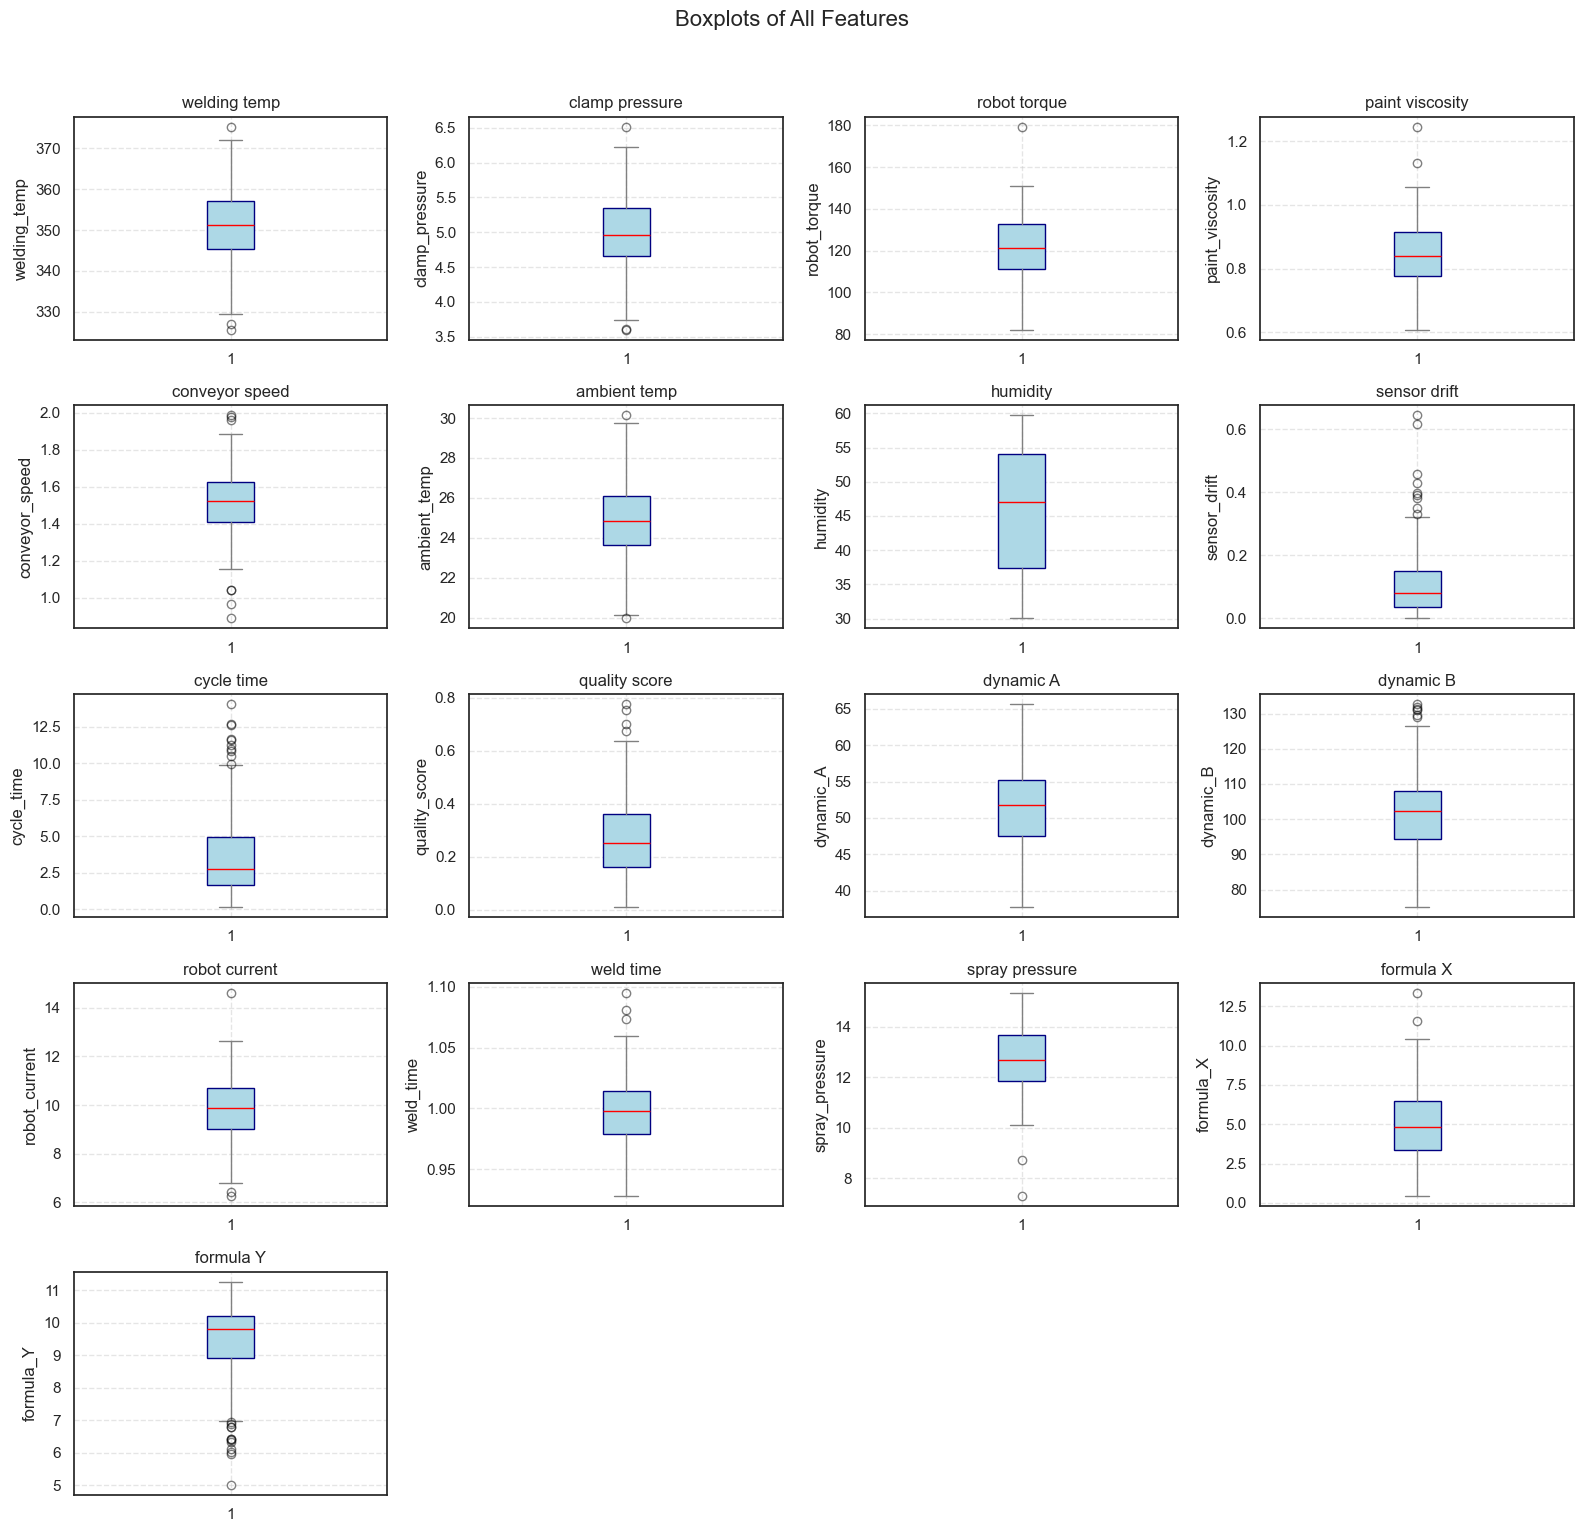

In [48]:
# Plotting boxplots for all features 


faultNumber=3
simulationRun = 1
df_selected_f_data = df_f_training[(df_f_training['faultNumber'] == faultNumber) & (df_f_training['simulationRun'] == simulationRun)]
df_select_ff_data = df_ff_training[(df_ff_training['faultNumber'] == 0) & (df_ff_training['simulationRun'] == simulationRun)]


used_data = df_select_ff_data

feature_columns = df_ff_training.columns[3:]
num_features = len(feature_columns)

# Define the number of rows and columns for the subplots in the grid
num_cols = min(4, num_features)  # Maximum of 4 columns
num_rows = int(np.ceil(num_features / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
fig.suptitle("Boxplots of All Features", fontsize=16, y=1.02)

for i, col in enumerate(feature_columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]

    ax.boxplot(used_data[col], patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='navy'),
           medianprops=dict(color='red'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='darkorange', alpha=0.5))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylabel(col)
    #ax.set_xticklabels([col], rotation=45)
    ax.set_title(col.replace("_"," "))


for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

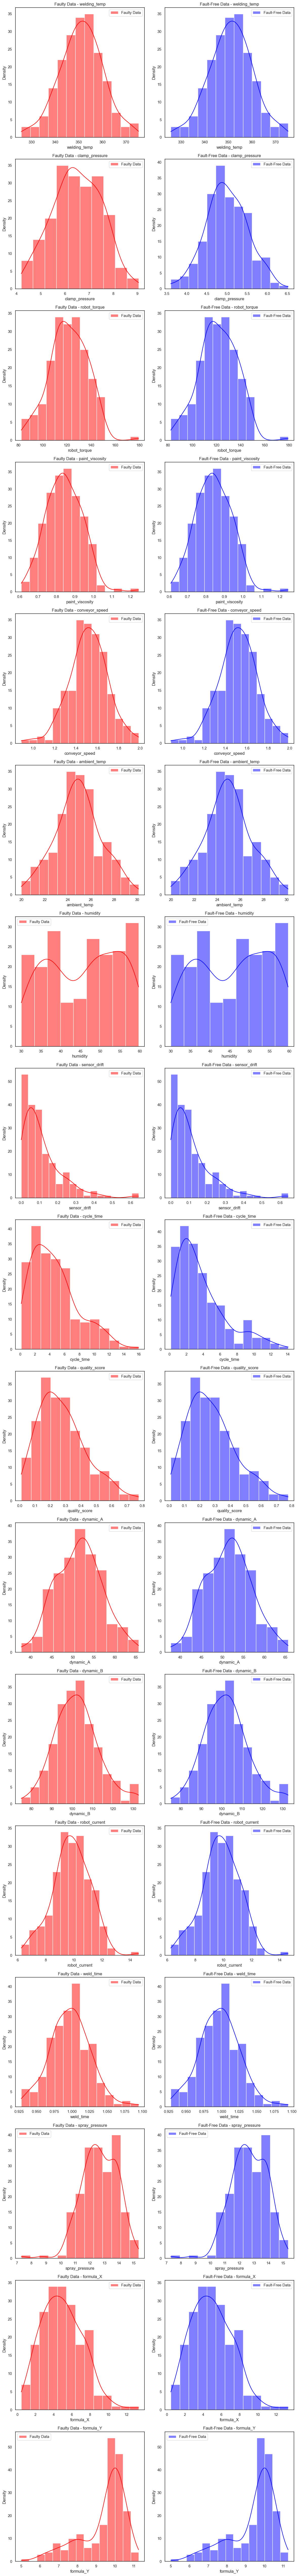

In [49]:
# Plotting distribution of selected features in f and ff beside each other to compare fault vs normal

faultNumber=2.0
simulationRun = 1
df_selected_f_data = df_f_training[(df_f_training['faultNumber'] == faultNumber) & (df_f_training['simulationRun'] == simulationRun)]
df_select_ff_data = df_ff_training[(df_ff_training['faultNumber'] == 0) & (df_ff_training['simulationRun'] == simulationRun)]

# plotting distribution of selected features f and ff beside each other to compare fault vs normal
# selected features to plot
#selected_features = ['xmeas_1', 'xmeas_2']
selected_features = df_selected_f_data.columns[3:]  # Select features from index 3 to the end
# Create a figure with subplots for each selected feature
fig, axes = plt.subplots(len(selected_features), 2, figsize=(12, 6 * len(selected_features)))
for i, feature in enumerate(selected_features):
    # Plotting the faulty data gaussian distribution
    sns.histplot(df_selected_f_data[feature], kde=True, ax=axes[i, 0], color='red', label='Faulty Data')
    axes[i, 0].set_title(f'Faulty Data - {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Density')            
    axes[i, 0].legend()
    # Plotting the fault-free data gaussian distribution
    sns.histplot(df_select_ff_data[feature], kde=True, ax=axes[i,
    1], color='blue', label='Fault-Free Data')
    axes[i, 1].set_title(f'Fault-Free Data - {feature}')
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel('Density')
    axes[i, 1].legend()
plt.tight_layout()
plt.show()

     

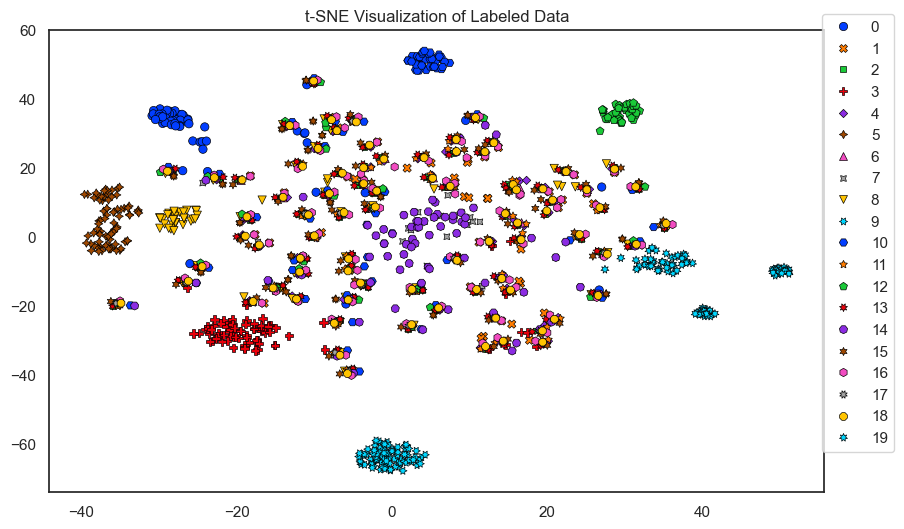

In [50]:
# Visualize class separation and structure in high-dimensional process data using t-SNE embedding to 2D.

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_visualization(x_f_train: np.ndarray, y_f_labeled_train: np.ndarray, step: int = 50) -> None:
    """
    Visualize class separation and structure in high-dimensional process data using t-SNE embedding to 2D.

    Input:
        x_f_train: High-dimensional feature matrix (e.g., 54 dimensions).
        y_f_labeled_train: 1D label array corresponding to x_f_train.
        step: Downsampling factor to reduce computational load (default=50).

    Output:
        A 2D scatter plot showing t-SNE projection colored and styled by labels.
    """

    # Downsample the data to reduce computation
    x_down = x_f_train[::step, :]
    y_label = y_f_labeled_train[::step]

    # Apply t-SNE to project high-dimensional data into 2D space
    x_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(x_down)

    # Create a scatter plot of the 2D embedded data
    f, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        x=x_embedded[:, 0],
        y=x_embedded[:, 1],
        hue=y_label,
        style=y_label,
        palette="bright",
        edgecolor='black'
    )
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title('t-SNE Visualization of Labeled Data')
    plt.show()

plot_tsne_visualization(x_f_train, y_f_labeled_train)  # Uncomment to run t-SNE visualization (heavy- take time)


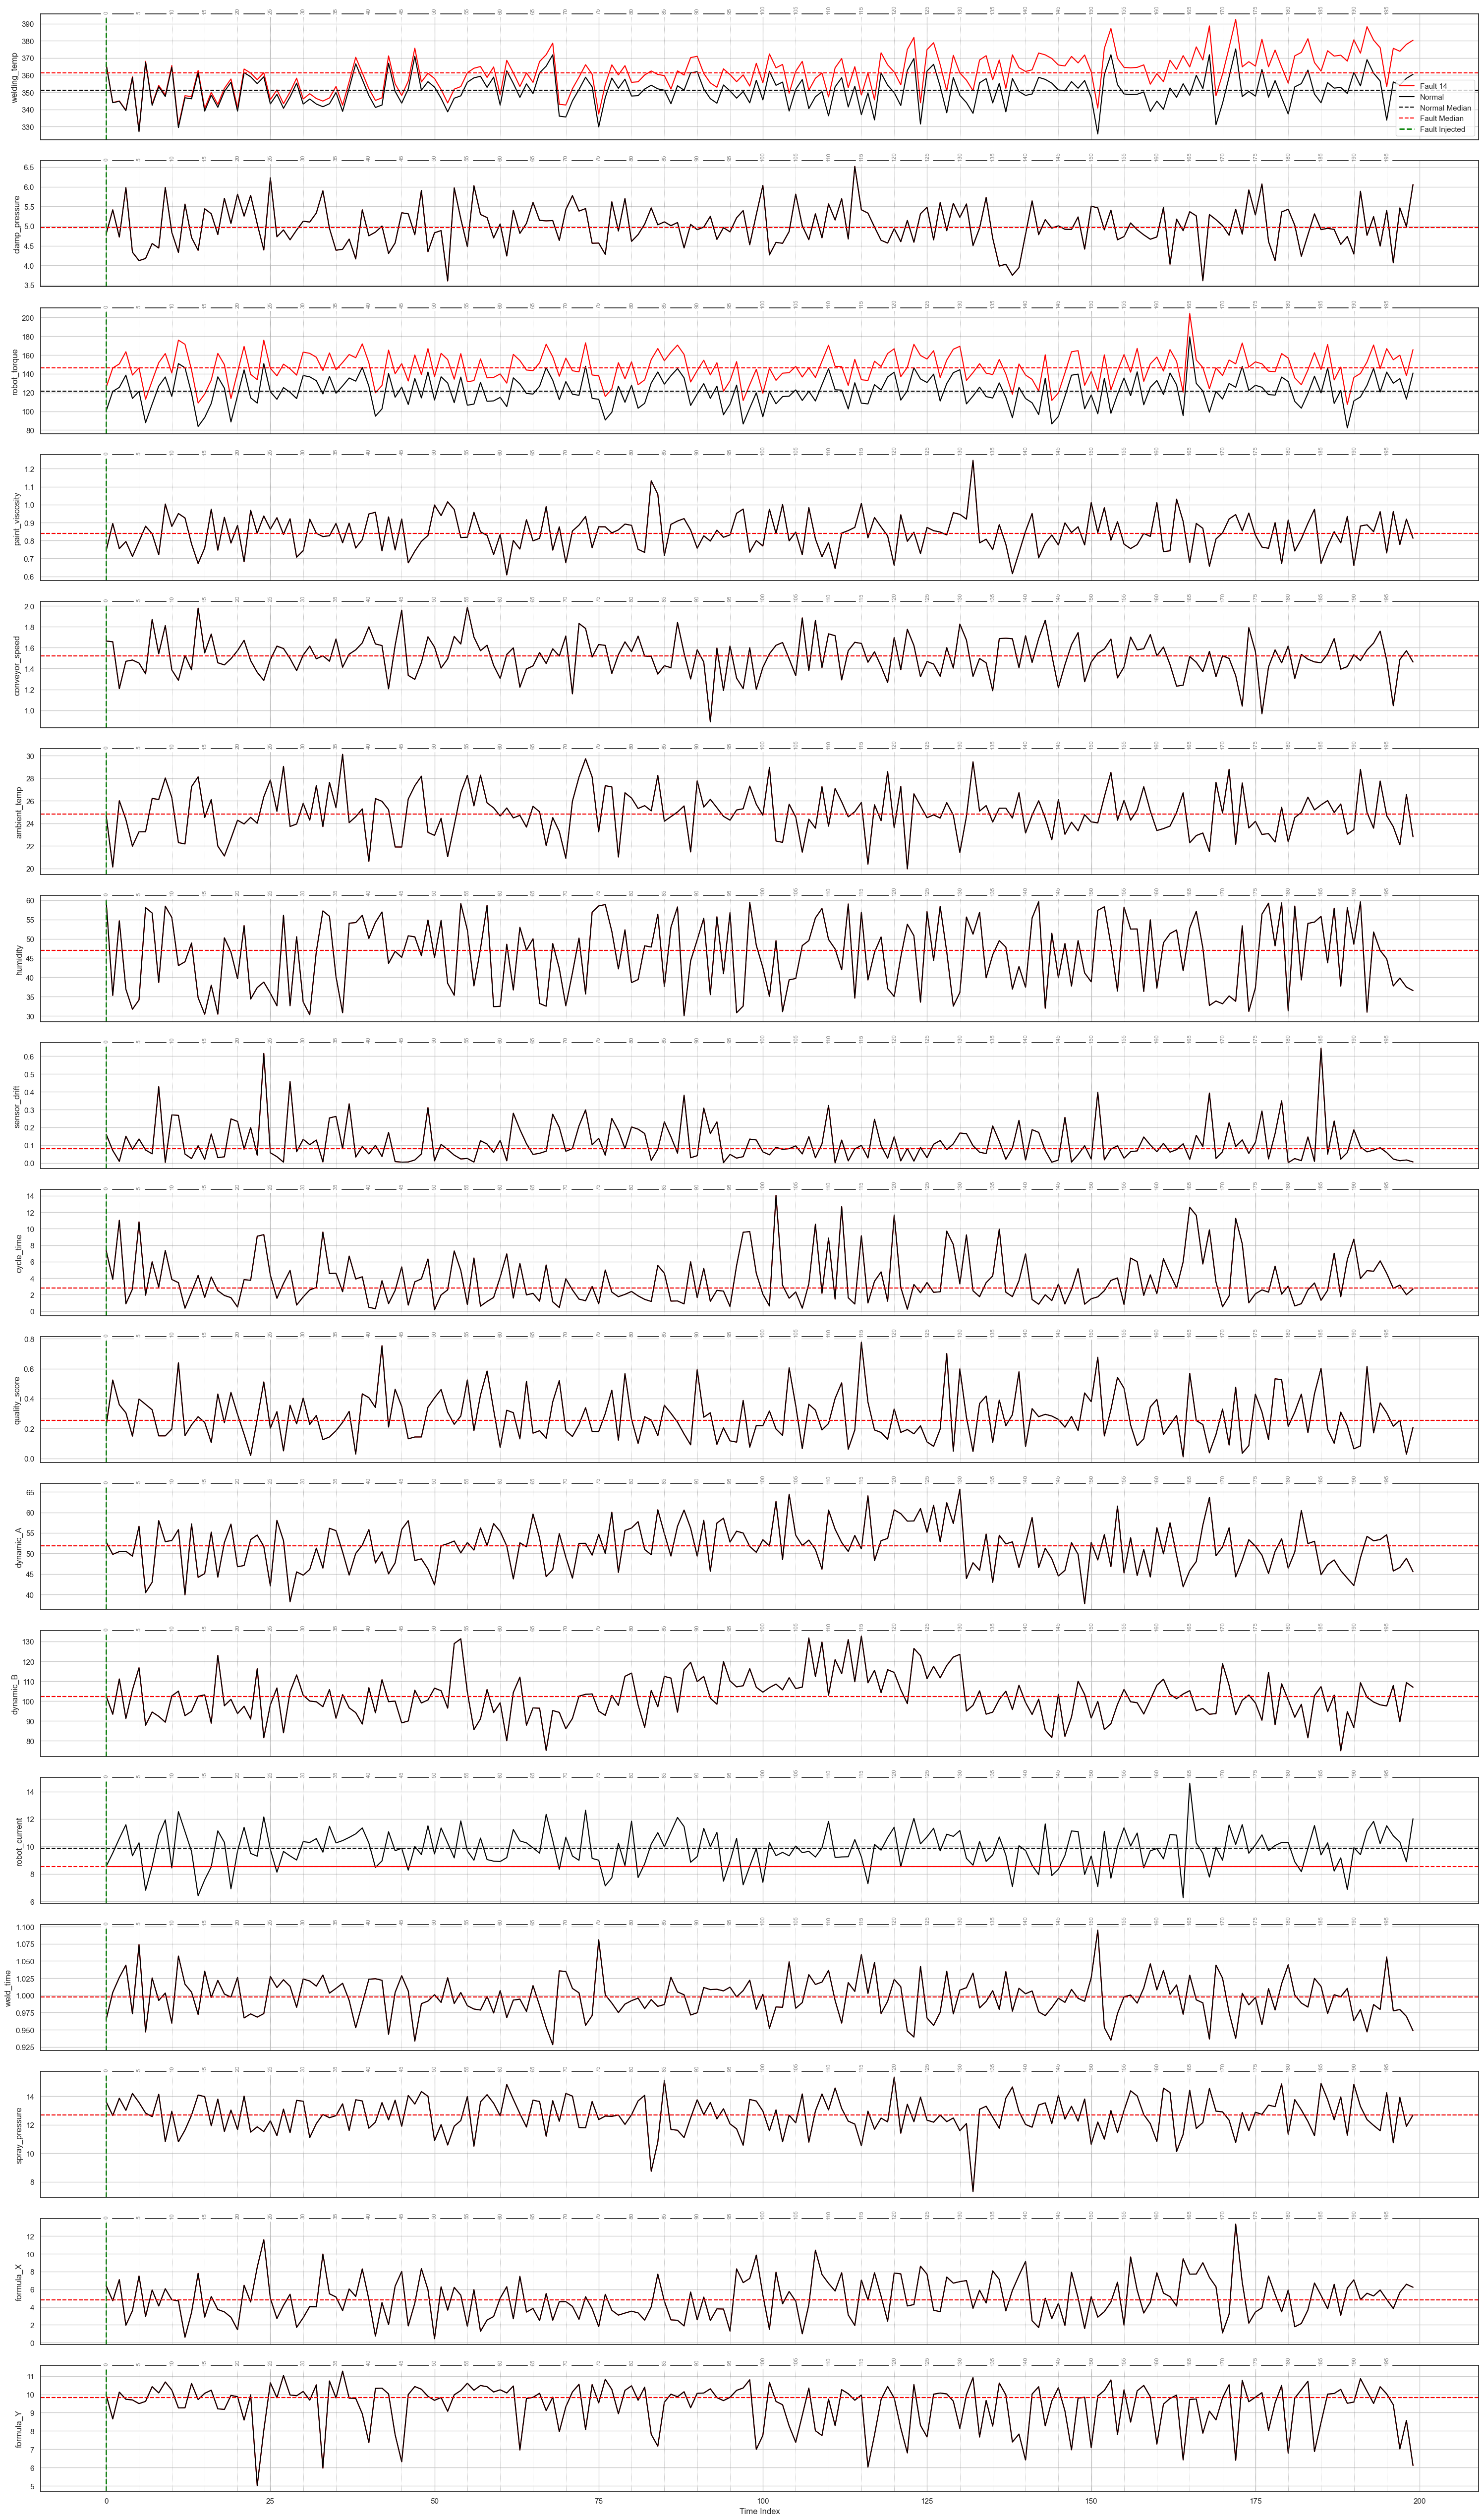

In [63]:
# Compare fault vs normal time series for selected features.
# This help to caputre the differences between faulty and normal segments of the time series data and determine the start of the fault injection.

simulationRun = 1.0
df_fault = df_f_training[(df_f_training['simulationRun'] == simulationRun)].reset_index(drop=True)
df_normal = df_ff_training[(df_ff_training['simulationRun'] == simulationRun)].reset_index(drop=True)


plot_fault_vs_normal_segment(
    df_fault=df_fault,
    df_normal=df_normal,
    features=df_f_training.
    columns[3:],  # Select all features, which strats from index 3
    point_start=0,
    point_end=200,
    fault_number=14,
    fault_injection_index=fault_injection_point)


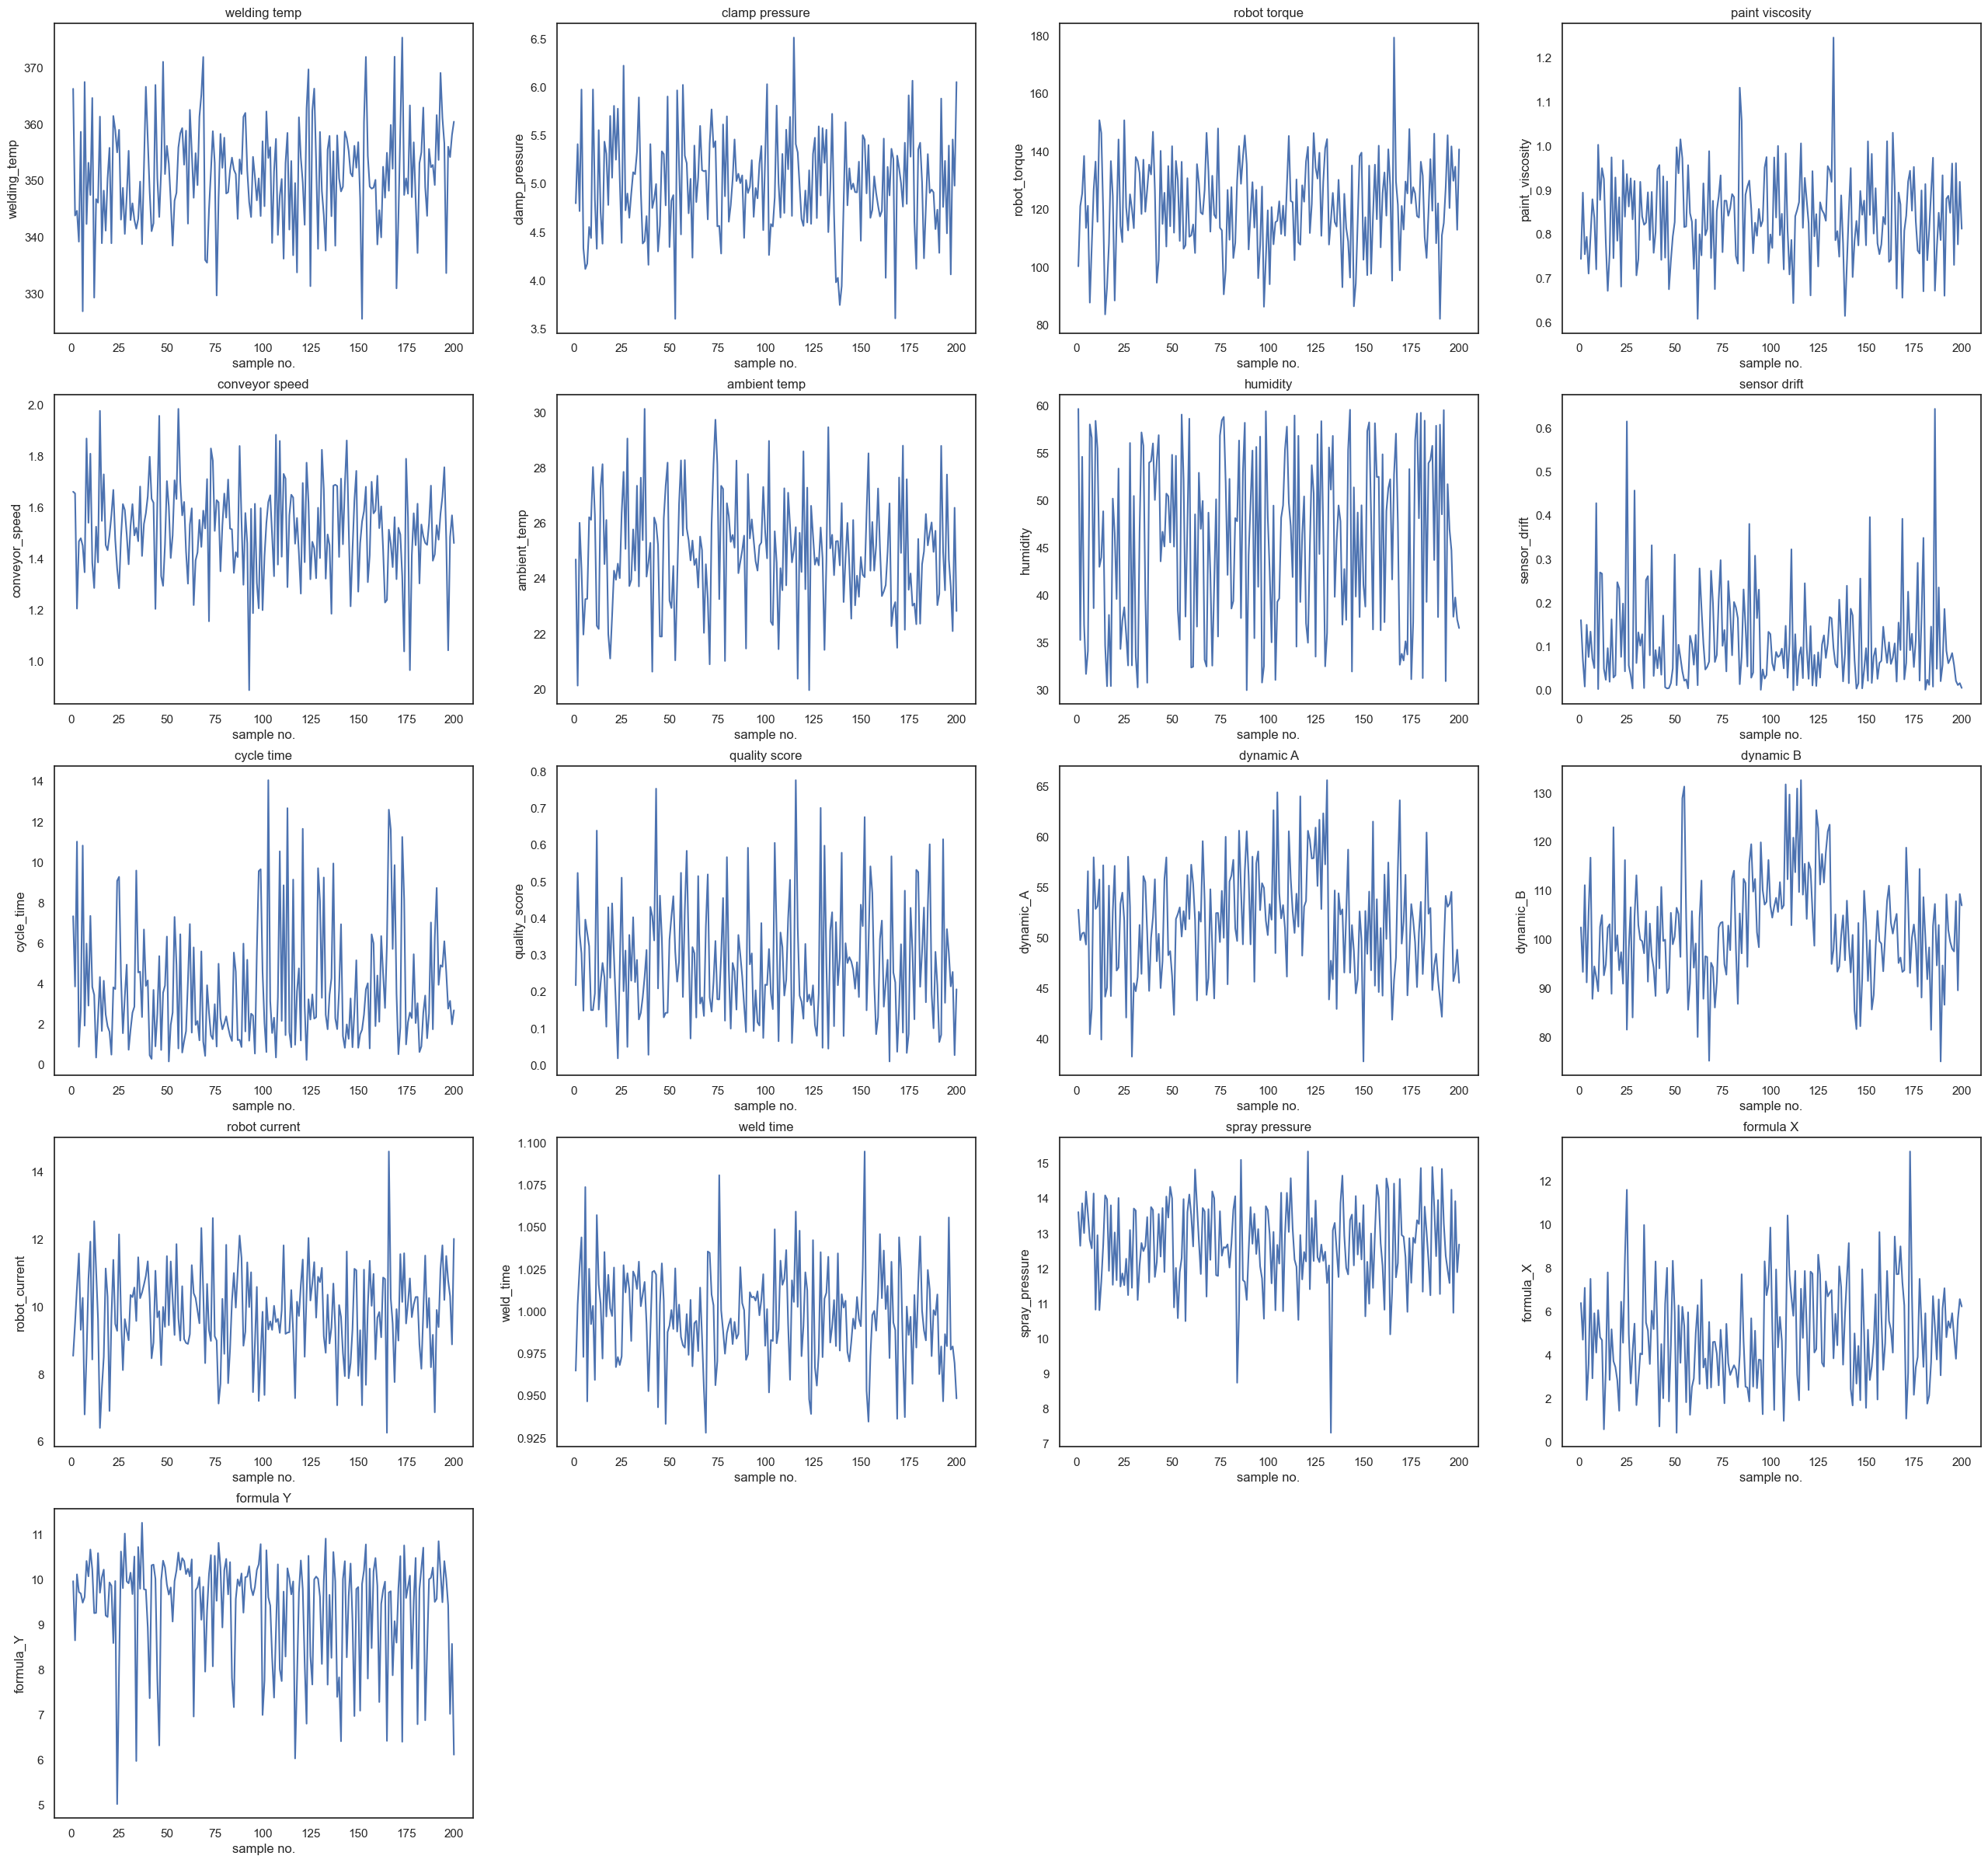

In [52]:
# Plotting Training Data for Simulation Run 1 and Fault Number 0
df_data_to_plot = df_ff_training[ (df_ff_training['faultNumber']==0) & (df_ff_training['simulationRun']==1) ]

feature_columns = df_normal.columns[3:]
num_features = len(feature_columns)

# Define the number of rows and columns for the subplots
num_cols = min(4, num_features)  # Maximum of 4 columns
num_rows = int(np.ceil(num_features / num_cols))
size_multiplier = 2  # Adjust this value to change the size of the subplots
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols * size_multiplier, 3 * num_rows * size_multiplier))

for i, col in enumerate(feature_columns):
    # Determine the row and column index (position) for the subplot in the grid
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]

    ax.plot(df_data_to_plot['sample'], df_data_to_plot[col])
    ax.set_xlabel('sample no.')
    ax.set_ylabel(col)
    ax.set_title(col.replace("_", " "))

for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

#plt.tight_layout()
#plt.show()


### TODO
- also show the features as time series to compare the similarty or the position of outliner
- create code the use partial correlaltion to match features the are partly similer to the same time points
- compare with mutual information algorithem

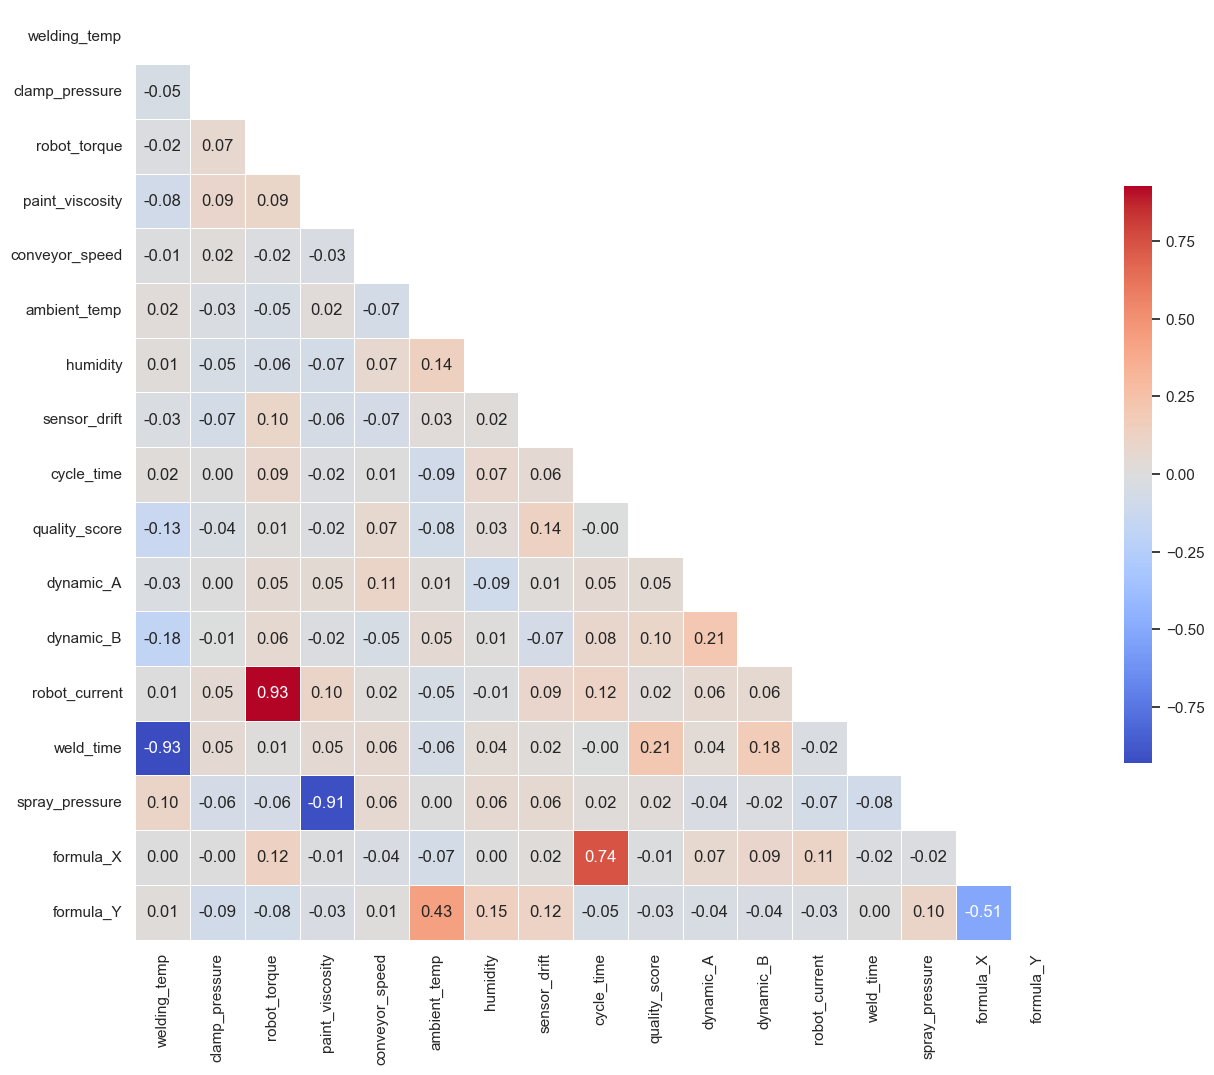

In [53]:
# Plotting the correlation matrix of the features

# Load the data into a pandas DataFrame
data = df_ff_training[df_ff_training['simulationRun']==1].iloc[:,3:]

# Calculate the correlation matrix
corr = data.corr()

# Create a heatmap with annotations
sns.set_theme(style='white')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

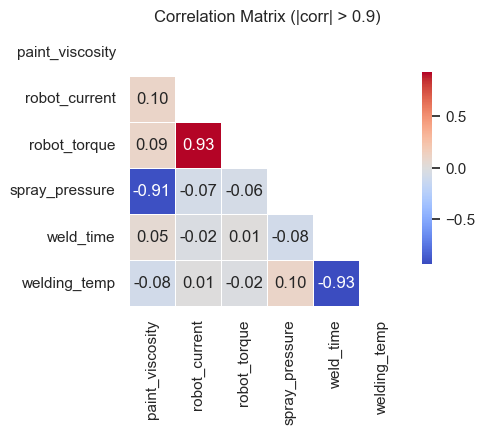

In [54]:
# Plotting the correlation matrix with a threshold
# Set correlation threshold
threshold: float = 0.9

# Load the data into a pandas DataFrame
data: pd.DataFrame = df_ff_training[df_ff_training['simulationRun'] == 1].iloc[:, 3:]

# Calculate correlation matrix
corr: pd.DataFrame = data.corr()

# Remove self-correlation (diagonal only)
corr_abs: pd.DataFrame = corr.abs().copy()
np.fill_diagonal(corr_abs.values, 0.0)



# Identify features with any correlation above threshold
selected_features: set[str] = set(corr_abs.columns[(corr_abs > threshold).any()])
selected_features_list: list[str] = sorted(selected_features)

# Filter correlation matrix to only those features
filtered_corr: pd.DataFrame = corr.loc[selected_features_list, selected_features_list]


# Plot heatmap
sns.set_theme(style='white')
mask: np.ndarray = np.triu(np.ones_like(filtered_corr, dtype=bool))

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    filtered_corr,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.title(f"Correlation Matrix (|corr| > {threshold})")
plt.tight_layout()
plt.show()


In [55]:
# Plotting high-correlation pairs with interactive widgets as Time Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Output, Dropdown

# 1. Compute correlation matrix and extract high-correlation pairs
data: pd.DataFrame = df_ff_training[df_ff_training['simulationRun'] == 1].iloc[:, 3:]
corr: pd.DataFrame = data.corr()

# Zero diagonal
corr_abs: pd.DataFrame = corr.abs().copy()
np.fill_diagonal(corr_abs.values, 0.0)

# Threshold
#threshold: float = 0.9
high_pairs = [
    (col1, col2, corr.loc[col1, col2])
    for i, col1 in enumerate(corr.columns)
    for j, col2 in enumerate(corr.columns)
    if j > i and isinstance(corr.loc[col1, col2], (float, np.floating)) and abs(corr.loc[col1, col2]) > threshold
]

# 2. Prepare dropdown options
pair_labels: list[str] = [f"{a} - {b} (corr={c:.2f})" for a, b, c in high_pairs]
pair_dict: dict[str, tuple[str, str]] = {label: (a, b) for label, (a, b, _) in zip(pair_labels, high_pairs)}
dropdown = Dropdown(options=pair_labels, description='Pair:')

# 3. Global state
index: int = 0
window_size: int = 150
out = Output()

# 4. Plot logic
def plot_selected_pair(start: int, feature1: str, feature2: str) -> None:
    global out
    series1: pd.Series = data[feature1].reset_index(drop=True)
    series2: pd.Series = data[feature2].reset_index(drop=True)
    mean1, std1 = series1.mean(), series1.std()
    mean2, std2 = series2.mean(), series2.std()

    end: int = min(start + window_size, len(series1))
    x = np.arange(start, end)
    y1 = series1[start:end]
    y2 = series2[start:end]

    with out:
        out.clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.plot(x, y1, label=feature1, color='blue')
        plt.plot(x, y2, label=feature2, color='red')
        
        plt.axhline(mean1, color='blue', linestyle='--')
        plt.axhline(mean1 + std1, color='blue', linestyle=':')
        plt.axhline(mean1 - std1, color='blue', linestyle=':')
        plt.axhline(mean2, color='red', linestyle='--')
        plt.axhline(mean2 + std2, color='red', linestyle=':')
        plt.axhline(mean2 - std2, color='red', linestyle=':')
        
        plt.title(f"{feature1} vs {feature2} [{start}:{end}]")
        plt.xlabel("Time Index")
        plt.ylabel("Value")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# 5. Button callbacks
def on_next_clicked(_):
    global index
    if index + window_size < len(data):
        index += window_size
        f1, f2 = pair_dict[dropdown.value]
        plot_selected_pair(index, f1, f2)

def on_back_clicked(_):
    global index
    if index - window_size >= 0:
        index -= window_size
        f1, f2 = pair_dict[dropdown.value]
        plot_selected_pair(index, f1, f2)

def on_dropdown_change(change):
    global index
    if change['type'] == 'change' and change['name'] == 'value':
        index = 0  # reset on pair change
        f1, f2 = pair_dict[change['new']]
        plot_selected_pair(index, f1, f2)

# Bind events
btn_next = Button(description='Next →')
btn_back = Button(description='← Back')
btn_next.on_click(on_next_clicked)
btn_back.on_click(on_back_clicked)
dropdown.observe(on_dropdown_change)

# Init plot
initial_f1, initial_f2 = pair_dict[dropdown.value]
plot_selected_pair(index, initial_f1, initial_f2)

# Show all widgets
VBox([dropdown, HBox([btn_back, btn_next]), out])


# Data preprocessing

# Supervised ML Approach


## Methode that works with LabelEncoded target variable Y

In [56]:
# Fit models to the data
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Create an instance of each algorithm
logreg = LogisticRegression(max_iter=10000)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
nb = GaussianNB()

svm = SVC()
rf = RandomForestClassifier()
xg = xgb.XGBClassifier()

# Train the algorithms on the data
# logreg.fit(x_train, y_labeled_train)
# knn.fit(x_train, y_labeled_train)
# dt.fit(x_train, y_labeled_train)
# nb.fit(x_train, y_labeled_train)

rf.fit(x_train, y_labeled_train)
xg.fit(x_train, y_labeled_train)
svm.fit(x_train, y_labeled_train)

# Use the trained models to make predictions on new data
# y_pred_logreg =logreg.predict(x_test)
# y_pred_dt = dt.predict(x_test)
# y_pred_nb = nb.predict(x_test)
# y_pred_knn = knn.predict(x_test)

y_pred_rf = rf.predict(x_test)
y_pred_xg = xg.predict(x_test)
y_pred_svm = svm.predict(x_test)

In [57]:
from typing import Optional
import numpy as np


class OrderedTreeClassifier:

    def __init__(self, max_depth: int = 3, min_samples_split: int = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree: Optional[dict] = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> dict:
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        if depth >= self.max_depth or num_samples < self.min_samples_split or num_classes == 1:
            return {"leaf": True, "class": self._majority_class(y)}

        # Force ordered traversal of features
        best_feature, best_threshold, best_gini = None, None, float("inf")
        best_left_idx, best_right_idx = None, None

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_idx = X[:, feature_index] <= threshold
                right_idx = ~left_idx
                if left_idx.sum() == 0 or right_idx.sum() == 0:
                    continue

                gini = self._gini_index(y[left_idx], y[right_idx])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = threshold
                    best_left_idx = left_idx
                    best_right_idx = right_idx

        if best_feature is None:
            return {"leaf": True, "class": self._majority_class(y)}

        return {
            "leaf":
            False,
            "feature":
            best_feature,
            "threshold":
            best_threshold,
            "left":
            self._build_tree(X[best_left_idx], y[best_left_idx], depth + 1),
            "right":
            self._build_tree(X[best_right_idx], y[best_right_idx], depth + 1)
        }

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x: np.ndarray, node: dict) -> int:
        if node["leaf"]:
            return node["class"]
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_one(x, node["left"])
        else:
            return self._predict_one(x, node["right"])

    def _gini_index(self, left_y: np.ndarray, right_y: np.ndarray) -> float:

        def gini(labels: np.ndarray) -> float:
            _, counts = np.unique(labels, return_counts=True)
            p = counts / counts.sum()
            return 1.0 - np.sum(p**2)

        n = len(left_y) + len(right_y)
        return (len(left_y) / n) * gini(left_y) + (len(right_y) /
                                                   n) * gini(right_y)

    def _majority_class(self, y: np.ndarray) -> int:
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]


# Sample usage
#ordered_tree = OrderedTreeClassifier(max_depth=4)
#ordered_tree.fit(x_train, y_labeled_train)
#y_ordered_tree_pred = ordered_tree.predict(x_test)

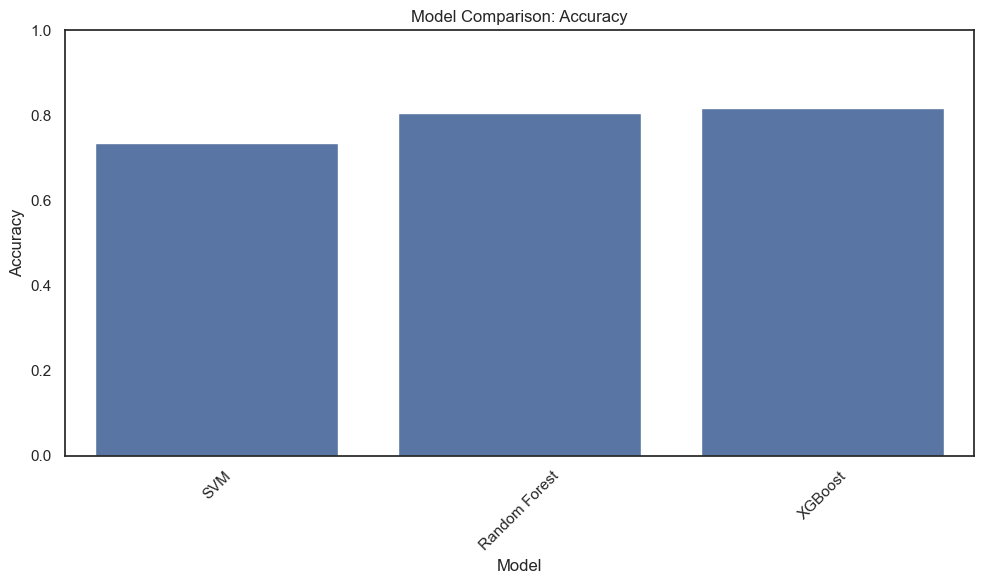

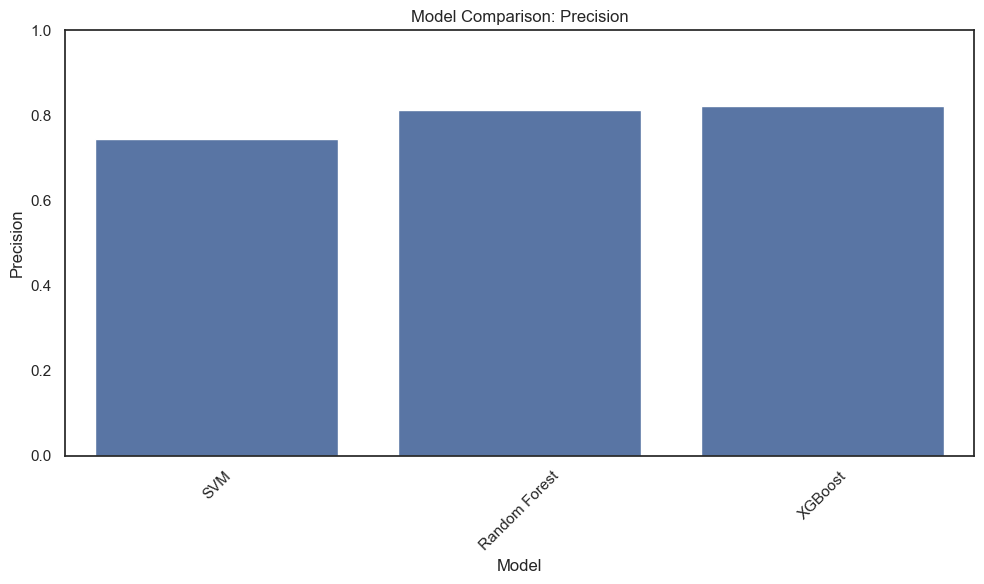

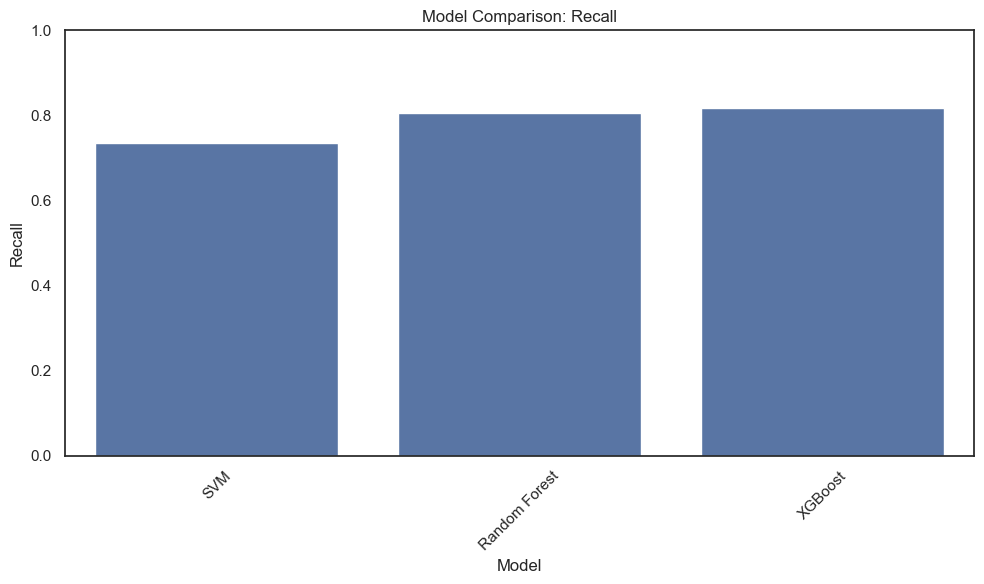

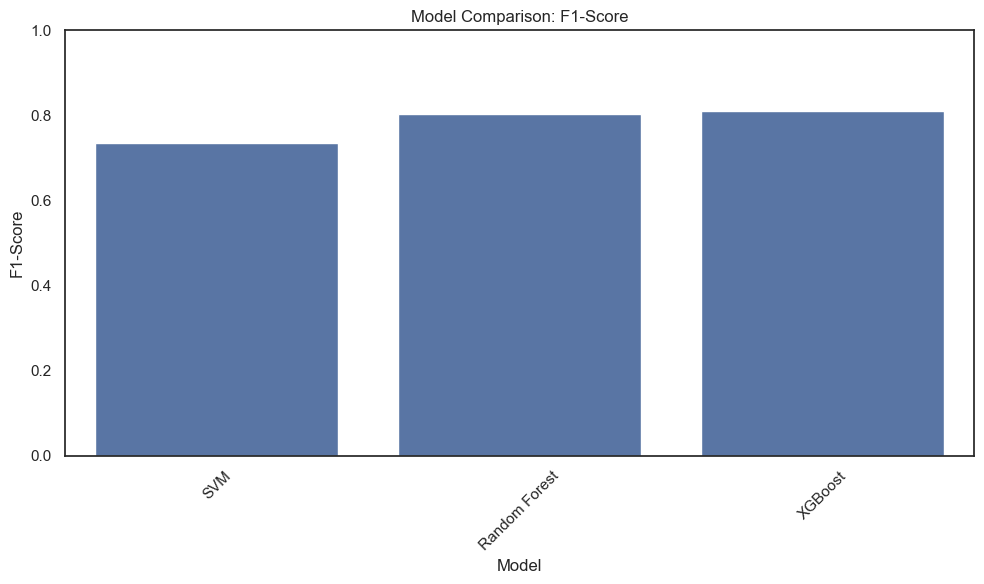

╒═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model         │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ XGBoost       │     0.8175 │      0.8231 │   0.8175 │     0.8104 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Random Forest │     0.8056 │      0.8124 │   0.8056 │     0.8044 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ SVM           │     0.7354 │      0.7438 │   0.7354 │     0.7343 │
╘═══════════════╧════════════╧═════════════╧══════════╧════════════╛


In [58]:
# Plotting the results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from typing import Union, List

# Function to plot confusion matrix
def plot_confusion_matrix(
    y_true: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray],
    title: str
) -> None:
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes: int = cm.shape[0]

    # Scale size based on number of classes
    width: float = max(6, num_classes * 0.8)
    height: float = max(4, num_classes * 0.6)

    f, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(num_classes, 0)
    plt.tight_layout()
    plt.show()

# List to collect results
models_results = []

# Store all metrics for each model
def evaluate_model(name: str, y_true, y_pred) -> None:
    acc = float(accuracy_score(y_true, y_pred))
    prec = float(precision_score(y_true, y_pred, average='macro', zero_division=0))
    rec = float(recall_score(y_true, y_pred, average='macro', zero_division=0))
    f1 = float(f1_score(y_true, y_pred, average='macro', zero_division=0))

    models_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
    })

# Evaluate all models
# evaluate_model('Logistic Regression', y_labeled_test, y_pred_logreg)
# evaluate_model('Naive Bayes', y_labeled_test, y_pred_nb)
# evaluate_model('Decision Tree', y_labeled_test, y_pred_dt)
# evaluate_model('KNN', y_labeled_test, y_pred_knn)
# evaluate_model('ordere', y_labeled_test, y_ordered_tree_pred)

evaluate_model('SVM', y_labeled_test, y_pred_svm)
evaluate_model('Random Forest', y_labeled_test, y_pred_rf)
evaluate_model('XGBoost', y_labeled_test, y_pred_xg)


# Convert results to DataFrame
results_df: pd.DataFrame = pd.DataFrame(models_results)

# Plot all metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Model', y=metric)
    plt.title(f'Model Comparison: {metric}')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Print table sorted by F1-score
print(tabulate(results_df.sort_values(by='F1-Score', ascending=False),headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".4f"))
#print(results_df.sort_values(by='F1-Score',ascending=False).to_string(index=False))


In [59]:
import joblib
#oblib.dump(logreg, 'exported-models/logistic_regression_model.pkl')
#joblib.dump(dt, 'exported-models/decision_tree_model.pkl')
#joblib.dump(rf, 'exported-models/random_forest_model.pkl')
#joblib.dump(nb, 'exported-models/naive_bayes_model.pkl')
#joblib.dump(knn, 'exported-models/knn_model.pkl')
#joblib.dump(xg, 'exported-models/xgboost_model.pkl')

### From above analysis, XGB and Random forest Performs well.
### Metrics:

In this series, we will use accuracy as the primary metric for evaluating the performance of the different machine learning algorithms. We will update the table as we evaluate the performance of other algorithms in the subsequently.


Average accuracy score obtained for each method, excluding fault No. 9 and 15 (**No feature were Dropped, all 52 sensor measurements were used**)

| Method                                    |Accuracy  |
|-----------------------------------------  |----------|
| XG Boost                                  |  0.887   |
| Neural Network                            |  0.943   |
| 1D CNN-Timeserise                         |  0.892   |
| LSTM-Timeserise                           |  0.924   |
| ANN+RandomForest                          |  0.936   |

## Methode that works with one hot encoded vector as target variable Y like Neural Network Fault Classification

In [60]:
from keras.layers import Input, Dense
from keras.models import Model

# Define input layer
inputs = Input(shape=(x_train.shape[1],))

# Define hidden layer with 16 nodes and ReLU activation function
hidden_layer = Dense(100, activation='selu')(inputs)
hidden_layer = Dense(100, activation='selu')(hidden_layer)
hidden_layer = Dense(100, activation='selu')(hidden_layer)
hidden_layer = Dense(100, activation='selu')(hidden_layer)
hidden_layer = Dense(100, activation='selu')(hidden_layer)
hidden_layer = Dense(100, activation='selu')(hidden_layer)
# Define output layer with softmax activation function for multi-class classification
outputs = Dense(y_one_hot_vector_enc_train.shape[1], activation='softmax')(hidden_layer)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 21)             │         2,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,421 (212.58 KB)

 Trainable params: 54,421 (212.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5744 - loss: 1.3949 - val_accuracy: 0.7164 - val_loss: 0.8463
Epoch 2/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7311 - loss: 0.7779 - val_accuracy: 0.7356 - val_loss: 0.7705
Epoch 3/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7416 - loss: 0.7269 - val_accuracy: 0.7480 - val_loss: 0.7181
Epoch 4/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7551 - loss: 0.6878 - val_accuracy: 0.7553 - val_loss: 0.6886
Epoch 5/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7633 - loss: 0.6494 - val_accuracy: 0.7653 - val_loss: 0.6743
Epoch 6/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7810 - loss: 0.5965 - val_accuracy: 0.7693 - val_loss: 0.6431
Epoch 7/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7846 - loss: 0.5880 - val_accuracy: 0.7709 - val_loss: 0.6463
Epoch 8/200
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7924 - loss: 0.5659 - val_accu

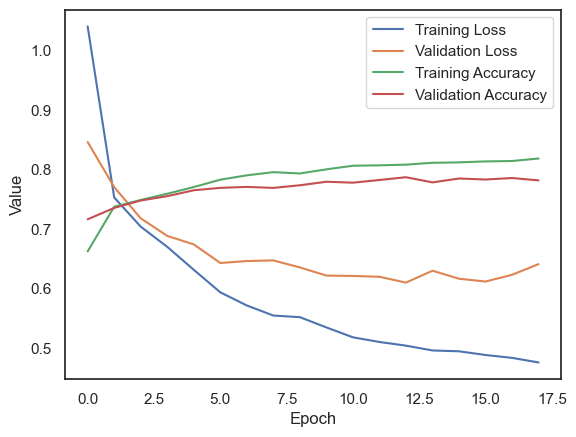

In [61]:
from keras.callbacks import EarlyStopping


# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(x_train, y_one_hot_vector_enc_train, epochs=200, batch_size=256, validation_data=(x_test, y_one_hot_vector_enc_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

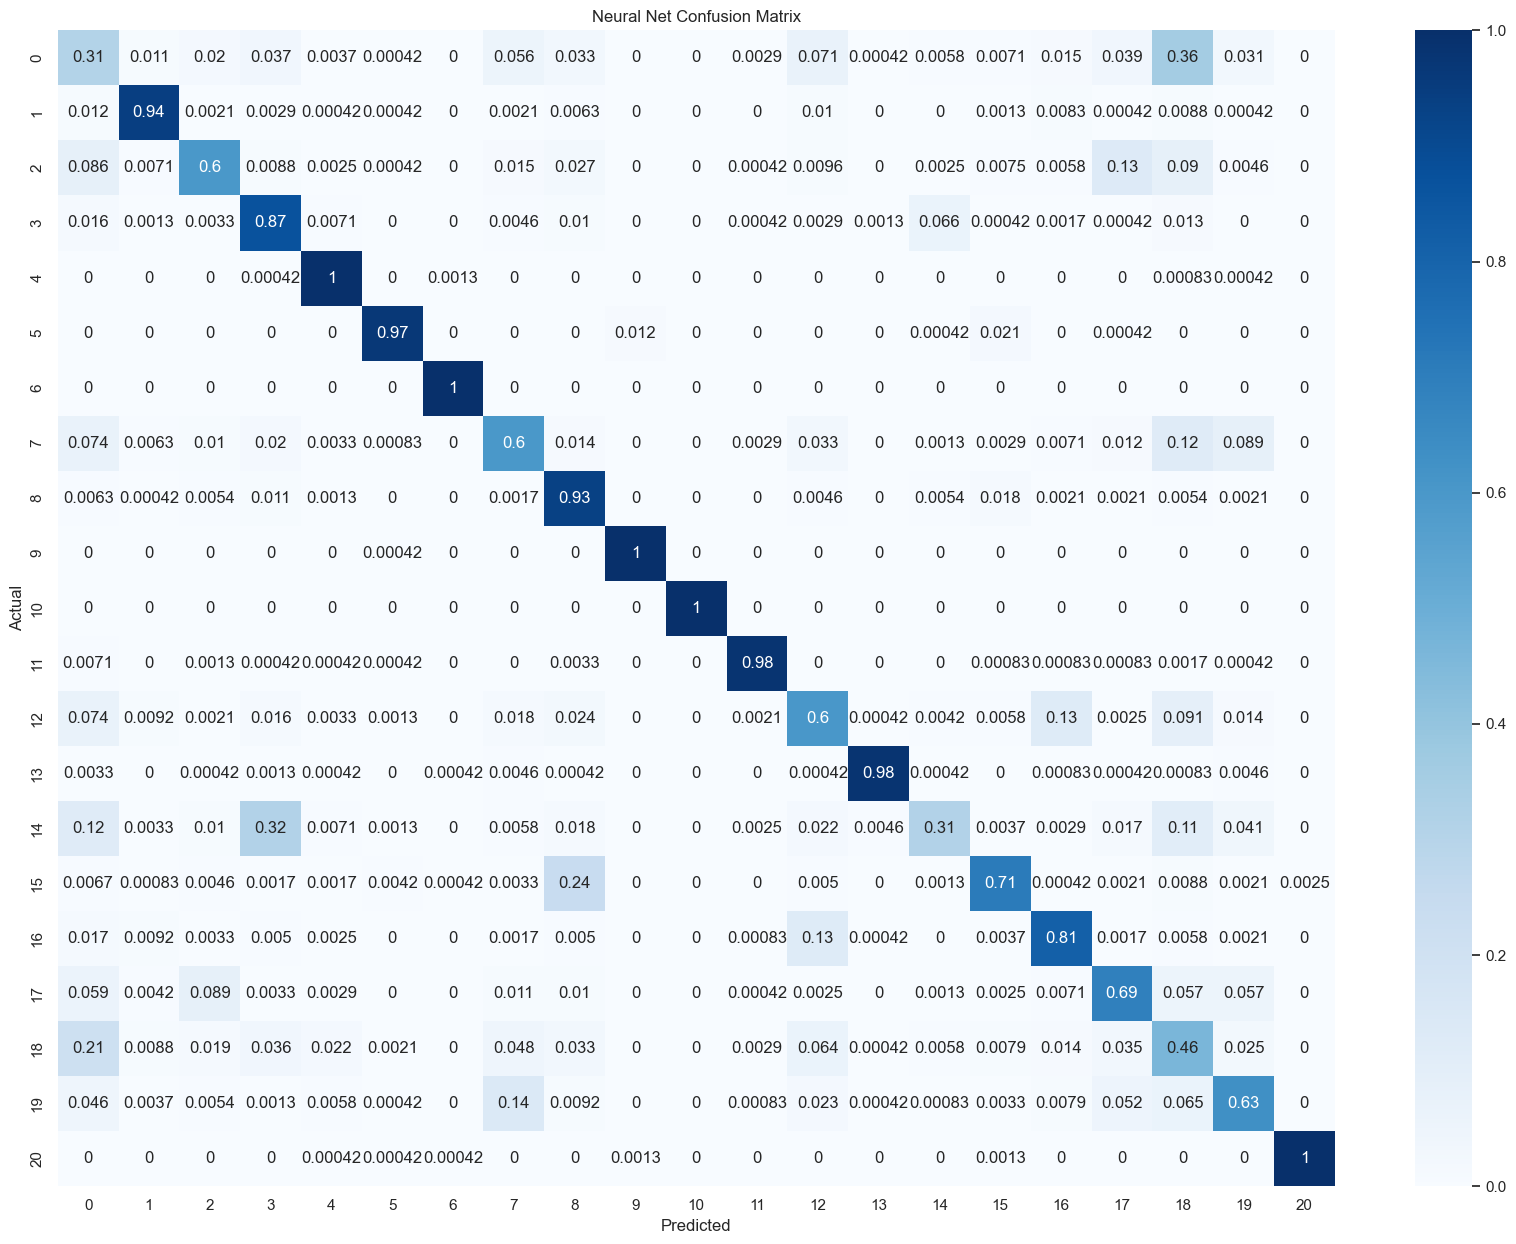

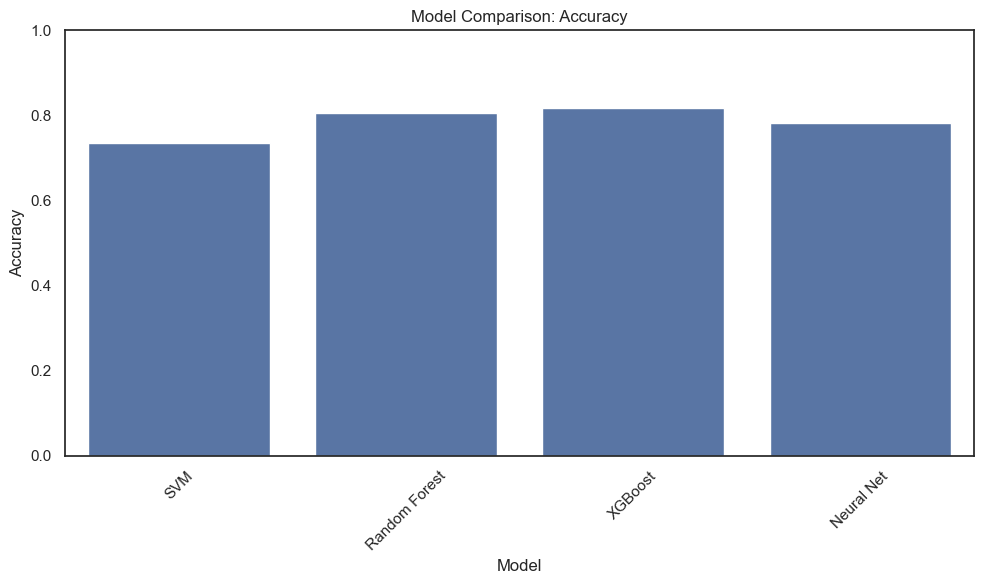

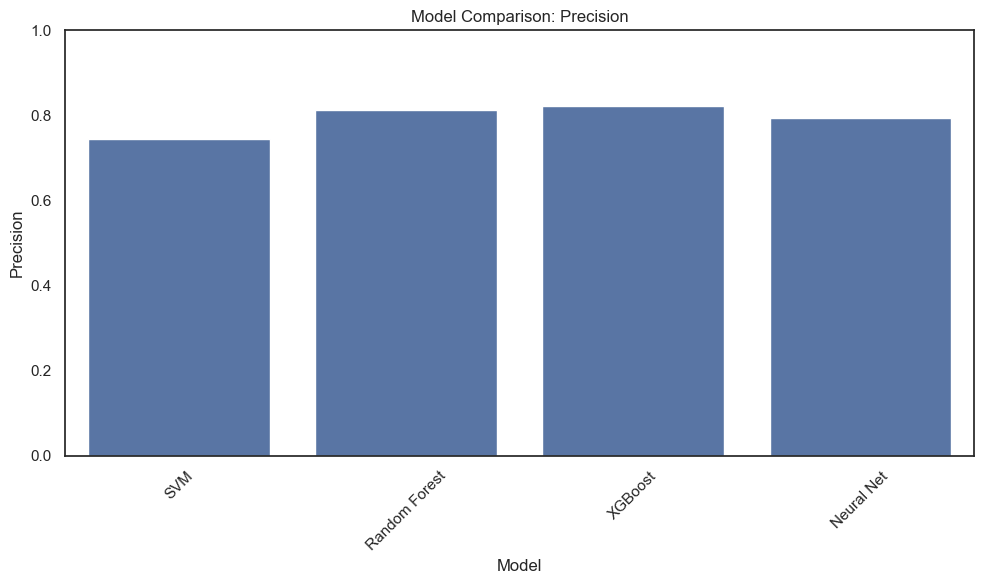

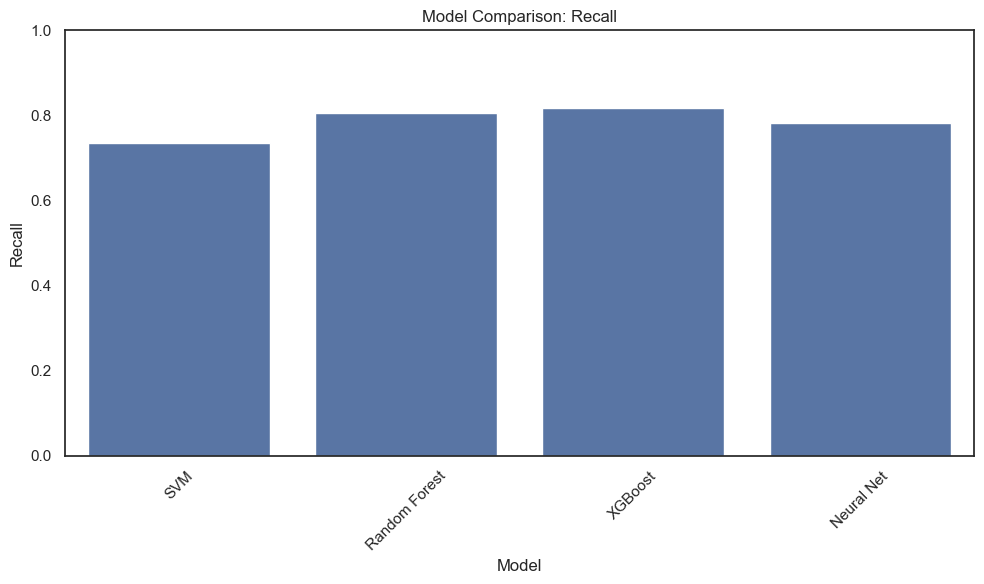

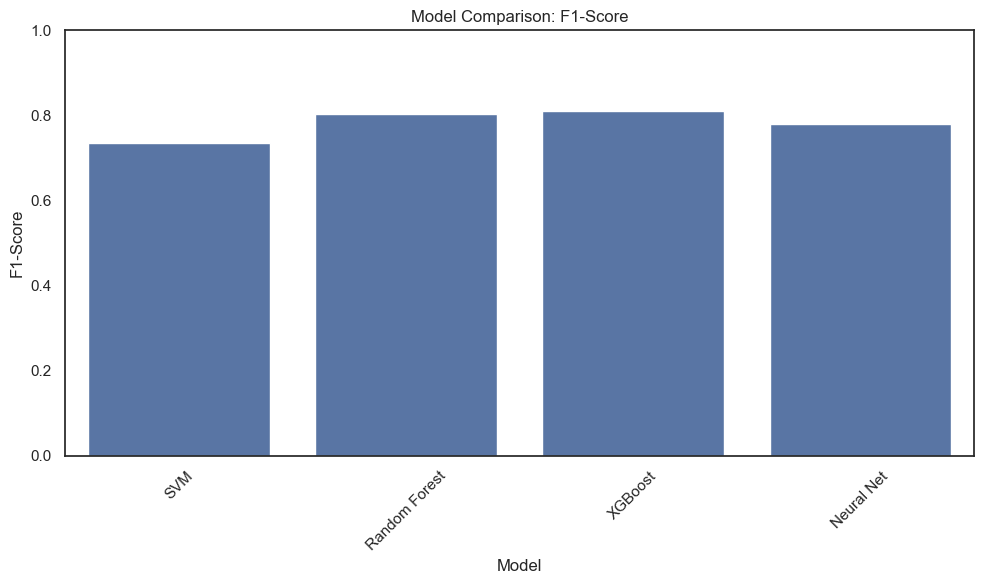

╒═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model         │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ XGBoost       │     0.8175 │      0.8231 │   0.8175 │     0.8104 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Random Forest │     0.8056 │      0.8124 │   0.8056 │     0.8044 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Neural Net    │     0.7818 │      0.7945 │   0.7818 │     0.7802 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ SVM           │     0.7354 │      0.7438 │   0.7354 │     0.7343 │
╘═══════════════╧════════════╧═════════════╧══════════╧════════════╛


In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from tabulate import tabulate


# Predict class labels
y_pred = encoder.inverse_transform(model.predict(x_test, verbose=0))
y_true = encoder.inverse_transform(y_one_hot_vector_enc_test)

# Optional confusion matrix
plot_confusion_matrix(y_true, y_pred, 'Neural Net Confusion Matrix')

# Compute all metrics
acc = float(accuracy_score(y_true, y_pred))
prec = float(precision_score(y_true, y_pred, average='macro', zero_division=0))
rec = float(recall_score(y_true, y_pred, average='macro', zero_division=0))
f1 = float(f1_score(y_true, y_pred, average='macro', zero_division=0))

try:
    y_score = model.predict(x_test, verbose=0)
    y_true_bin = label_binarize(y_true, classes=sorted(set(y_true)))
    auc = float(roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr'))
except Exception:
    auc = float('nan')

# Append to results
models_results.append({
    'Model': 'Neural Net',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    #'ROC-AUC': auc
})

# Create updated results DataFrame
results_df = pd.DataFrame(models_results)

# Plot all metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Model', y=metric)
    plt.title(f'Model Comparison: {metric}')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display final comparison table
print(tabulate(results_df.sort_values(by='F1-Score', ascending=False),headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".4f"))
